In [1]:
!java -version

openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Homebrew (build 17.0.16+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.16+0, mixed mode, sharing)


In [2]:
import base64
import json
import os
import secrets
from decimal import Decimal
from typing import Union

import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import pyspark
import seaborn as sns
from delta import *
from dotenv import load_dotenv
from pyspark.sql.functions import (
    col,
    count,
    datediff,
    dayofweek,
    floor,
    from_json,
    hour,
    lower,
    map_keys,
    month,
    sha2,
    split,
    sum,
    timestamp_micros,
    to_timestamp,
    trim,
    udf,
    when,
    concat_ws,
)

from pyspark.sql.types import (
    BooleanType,
    DateType,
    DecimalType,
    FloatType,
    IntegerType,
    LongType,
    StringType,
    StructField,
    StructType,
)
from shapely.geometry import Point

load_dotenv()


True

In [3]:
builder = (
    pyspark.sql.SparkSession.builder.appName("MyApp")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config(
        "spark.sql.catalog.spark_catalog",
        "org.apache.spark.sql.delta.catalog.DeltaCatalog",
    )
    .config("spark.driver.memory", "4g")
)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

print("SparkSession initialized with Delta Lake support.")

:: loading settings :: url = jar:file:/Users/linjiayuan/Development/paynet_test/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /Users/linjiayuan/.ivy2.5.2/cache
The jars for the packages stored in: /Users/linjiayuan/.ivy2.5.2/jars
io.delta#delta-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f0f742fa-63a2-4498-ad5b-d1e85eea770c;1.0
	confs: [default]
	found io.delta#delta-spark_2.13;4.0.0 in central
	found io.delta#delta-storage;4.0.0 in central
	found org.antlr#antlr4-runtime;4.13.1 in central
:: resolution report :: resolve 66ms :: artifacts dl 3ms
	:: modules in use:
	io.delta#delta-spark_2.13;4.0.0 from central in [default]
	io.delta#delta-storage;4.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.13.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules

SparkSession initialized with Delta Lake support.


In [4]:
df = spark.read.option("inferSchema", "true").json("dataset/cc_sample_transaction.json")
df.printSchema()
df.show(truncate=False)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------

# Data Quality Assurance Process

## 1. Introduction

Our approach to data quality assurance is a systematic, multi-stage process designed to transform the raw, semi-structured JSON data into a clean, reliable, and analysis-ready dataset. The process involves identifying common data quality issues such as inconsistent data types, structural anomalies, non-standard null values, and unstructured text fields, and then applying a series of targeted transformations in PySpark to rectify them.

## 2. Identification of Data Quality Issues

Upon initial analysis of the raw JSON data, the following key data quality challenges were identified:

* **Incorrect Data Types:** Many fields representing numbers (`amt`, `cc_num`, `merch_lat`), dates (`trans_date_trans_time`), and booleans (`is_fraud`) were loaded as strings, preventing accurate calculations and analysis.
* **Complex Nested Structures:** The `personal_detail` field was not a true nested object but a string containing escaped JSON. Furthermore, the `address` field within it was also a stringified JSON, requiring a multi-level parsing strategy.
* **Inconsistent and "Dirty" Text:** The `person_name` field contained highly unstructured data with various issues, including:
    * Non-standard delimiters (`|`, `@`).
    * Junk text and suffixes (e.g., `eeeee`, `NOOOO`).
    * Extraneous punctuation (`!`) and inconsistent spacing/commas.
* **Non-Standard Null Values:** Missing data was represented inconsistently using multiple strings (e.g., `"Null"`, `"NA"`, `"n/a"`), different cases (e.g., `"null"`), and empty strings (`""`), which are not automatically recognized as `null` by Spark.

## 3. Data Processing and Cleaning Methodology

The following sequential steps were implemented in the PySpark code to process and clean the identified issues:

### Step 1: Correcting Data Types (Casting)

The first step was to enforce a correct and consistent schema. After the initial load, an explicit casting operation was performed on each column to convert it to its proper data type. For example:

* `trans_date_trans_time` was converted to `TimestampType`.
* `amt` and `merch_lat`/`merch_long` were converted to `DecimalType`.
* `is_fraud` was converted to `BooleanType`.
* `cc_num` was converted to `LongType`.

This ensures that all data is in a usable format for subsequent transformations and analysis.

### Step 2: Flattening Nested JSON Structures

A multi-level parsing strategy was used to handle the `personal_detail` column:

1.  A schema (`personal_detail_schema`) was defined to parse the main JSON string, intentionally reading the nested `address` field as a `StringType`.
2.  The `from_json` function was applied to create a structured column (`pd`).
3.  A second `from_json` call was then applied to the `pd.address` string using a separate `address_schema` to parse the final level of nesting.
4.  Finally, all the fields from these new structs were selected into top-level columns, and the intermediate columns were dropped.

### Step 3: Cleaning and Normalizing Unstructured Text

A custom User-Defined Function (UDF), `clean_name_string`, was created to process the `person_name` field. This UDF performs a series of regular expression substitutions to:

1.  **Standardize Delimiters:** Replace `|` and `@` characters with a standard comma.
2.  **Remove Junk Data:** A regex `(\s*,?\s*(?:\b\w*?(.)\2{2,}\w*\b),?)|(!+)` is used to find and remove both junk words (like `NOOOO`) and all exclamation marks.
3.  **Collapse Duplicates:** Another regex `(,\s*){2,}` collapses any sequence of multiple commas and spaces into a single, clean comma.

The cleaned name string was then split into `First` and `Last` name columns.

### Step 4: Standardizing Null Values

To handle inconsistent missing values, a final cleaning pass was performed across all string columns in the DataFrame. This process uses a `when()` expression to:

1.  Convert the column value to lowercase using `lower()`.
2.  Check if the lowercase value is in a predefined list of null-like strings (`["na", "null", "n/a"]`).
3.  Check if the column is an empty string (`""`).

If any of these conditions are met, the value is replaced with a standard `null`. This case-insensitive approach ensures all forms of missing data are standardized, making the dataset robust and reliable.

In [5]:
df = (
    df
    .withColumn("trans_date_trans_time", to_timestamp(col("trans_date_trans_time")))
    .withColumn("merch_eff_time", timestamp_micros(col("merch_eff_time").cast(LongType())))
    .withColumn("is_fraud", col("is_fraud").cast(BooleanType()))
    .withColumn("merch_lat", col("merch_lat").cast(DecimalType(32, 10)))
    .withColumn("merch_long", col("merch_long").cast(DecimalType(32, 10)))
    .withColumn("merch_zipcode", col("merch_zipcode").cast(IntegerType()))
    .withColumn("amt", col("amt").cast(DecimalType(32, 2)))
    .withColumn("cc_num", col("cc_num").cast(LongType()))
)
df.show(truncate=False)
df.printSchema()

+----------+------+-------------+-----------+-------------------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |personal_detail                                                                                                                                                                                                                                      

In [6]:
personal_detail = df.select(col("personal_detail")).first()["personal_detail"]
personal_detail_json = json.loads(personal_detail)
personal_detail_json

{'person_name': 'Jennifer,Banks,eeeee',
 'gender': 'F',
 'address': '{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}',
 'lat': '36.0788',
 'long': '-81.1781',
 'city_pop': '3495',
 'job': 'Psychologist, counselling',
 'dob': '1988-03-09'}

In [7]:
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True),
])

personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),
    StructField("lat", DecimalType(32, 10), True),
    StructField("long", DecimalType(32, 10), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", DateType(), True),
])

df = (
    df
    .withColumn("pd", from_json(col("personal_detail"), personal_detail_schema))
    .withColumn("address", from_json(col("pd.address"), address_schema))
    .select(
        "*",
        "pd.person_name",
        "pd.gender",
        "pd.address",
        "pd.lat",
        "pd.long",
        col("pd.city_pop").cast(IntegerType()).alias("city_pop"),
        "pd.job",
        "pd.dob",
        "address.street",
        "address.city",
        "address.state",
        col("address.zip").cast(IntegerType()).alias("zip"),
    ).drop("pd", "address", "personal_detail")
)
df.show(truncate=False)
df.printSchema()

+----------+------+-------------+-----------+-------------------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+---------------------+--------------------------------+-------------------------+------+-------------+---------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |person_name              |gender|lat          |long           |city_pop|job                                          |dob       |street                        |city                    |state|zip  |
+----------+------+-------------+-----------+-------------------+--------+--

In [8]:
class MaskingUtils:
    @staticmethod
    def encrypt_str_data(secret_key: bytes, alphabet: str):
        import pyffx
        
        def encrypt(data: str):
            if data is None or data == "":
                return None
            
            cipher = pyffx.String(secret_key, alphabet=alphabet, length=len(data))
            return cipher.encrypt(data)
        
        return udf(encrypt, StringType())

    @staticmethod
    def decrypt_str_data(secret_key: bytes, alphabet: str):
        import pyffx
        
        def decrpyt(data: str):   
            if data is None or data == "":
                return None
            
            cipher = pyffx.String(secret_key, alphabet=alphabet, length=len(data))
            return cipher.decrypt(data)
        
        return udf(decrpyt, StringType())
    
    @staticmethod
    def encrypt_int_data(secret_key: bytes):
        import pyffx
        import math
        
        def encrypt(data: int):
            if data is None:
                return None
            
            cipher = pyffx.Integer(secret_key, length=int(math.log10(data))+1)
            return cipher.encrypt(data)
        
        return udf(encrypt, StringType())

    @staticmethod
    def decrypt_int_data(secret_key: bytes):
        import pyffx
        import math
        
        def decrpyt(data: int):    
            if data is None:
                return None
            
            cipher = pyffx.Integer(secret_key, length=int(math.log10(data))+1)
            return cipher.decrypt(data)
        
        return udf(decrpyt, StringType())
    
    @staticmethod
    def add_location_noise():
        import numpy as np
        import math
        
        location_schema = StructType(
            [
                StructField("long", DecimalType(32, 10), nullable=True),
                StructField("lat", DecimalType(32, 10), nullable=True),
            ]
        )
        
        def add_location_noise(lat: Union[float, Decimal, int], lon: Union[float, Decimal, int], noise_level_meters: int = 500) -> tuple[float, float]:
            """
            Adds random noise to a latitude/longitude coordinate.

            Args:
                lat: The original latitude.
                lon: The original longitude.
                noise_level_meters: The approximate maximum distance in meters to shift the location.

            Returns:
                A tuple containing the new (noisy) latitude and longitude.
            """
            if lat is None or lon is None:
                return np.nan, np.nan

            lat = float(lat)
            lon = float(lon)
            
            # 1. Convert noise level from meters to degrees
            # One degree of latitude is approximately 111,132 meters
            lat_noise = np.random.uniform(-noise_level_meters, noise_level_meters) / 111132
            
            # Longitude conversion depends on latitude
            lon_noise = np.random.uniform(-noise_level_meters, noise_level_meters) / (111320 * math.cos(math.radians(lat)))

            # 2. Add random noise to the original coordinates
            noisy_lat = lat + lat_noise
            noisy_long = lon + lon_noise

            return Decimal(noisy_lat), Decimal(noisy_long)

        
        return udf(add_location_noise, location_schema)
    

class Utils:
    def clean_name_string():
        import re
        
        def process_name_string(text: str) -> str:
            """
            Cleans a name string by:
            1. Replacing '|' and '@' with a comma and space.
            2. Removing words with characters repeated more than twice.
            3. Removing all exclamation marks.
            4. Collapsing multiple commas into a single comma.
            """
            if not isinstance(text, str):
                return ""

            # Step 1: Standardize delimiters by replacing '|' and '@'
            cleaned_text = re.sub(r"[|/@]", ", ", text)

            # Step 2: Remove bad words (like "Nooooo") and exclamation marks
            pattern_bad_words = r"(\s*,?\s*(?:\b\w*?(.)\2{2,}\w*\b),?)|(!+)"
            cleaned_text = re.sub(pattern_bad_words, "", cleaned_text, flags=re.IGNORECASE)

            # Step 3: Collapse multiple commas (like ", ,") into one
            pattern_commas = r"(,\s*){2,}"
            cleaned_text = re.sub(pattern_commas, ", ", cleaned_text)

            # Final cleanup of any leading/trailing whitespace or commas
            return cleaned_text.strip(" ,")
        
        return udf(process_name_string, StringType())
    
    def haversine_distance():
        import math
        
        def _haversine_distance(lat1, lon1, lat2, lon2):
            """
            Calculate the distance between two points on Earth in kilometers.
            """
            if any(v is None for v in [lat1, lon1, lat2, lon2]):
                return None

            R = 6371  # Earth radius in kilometers

            lat1_rad, lon1_rad = math.radians(float(lat1)), math.radians(float(lon1))
            lat2_rad, lon2_rad = math.radians(float(lat2)), math.radians(float(lon2))

            dlon = lon2_rad - lon1_rad
            dlat = lat2_rad - lat1_rad

            a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

            distance = R * c
            return distance
        
        return udf(_haversine_distance, FloatType())
    
    


In [9]:
def generate_aes_256_key():    
    key_bytes = secrets.token_bytes(32)
    key_string = base64.b64encode(key_bytes).decode('utf-8')
    
    return key_string


secret_key = os.getenv("ENCRYPT_SECRET_KEY")
if not secret_key:
    secret_key = generate_aes_256_key()
    print("Please update the .env file with the following value:")
    print(f"ENCRYPT_SECRET_KEY={secret_key}")
    
secret_key = base64.b64decode(secret_key)

In [10]:
encrypt_num_udf = MaskingUtils.encrypt_int_data(secret_key)
decrypt_num_udf = MaskingUtils.decrypt_int_data(secret_key)
encrypt_str_udf = MaskingUtils.encrypt_str_data(secret_key, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789. ")
decrypt_str_udf = MaskingUtils.decrypt_str_data(secret_key, "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789. ")
location_noise_udf = MaskingUtils.add_location_noise()
clean_name_udf = Utils.clean_name_string()
haversine_udf = Utils.haversine_distance()


In [11]:
df = df.withColumn("cleaned_person_name", clean_name_udf(col("person_name"))).drop("person_name")
df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+---------------------+--------------------------------+------+-------------+---------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+----------------------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |gender|lat          |long           |city_pop|job                                          |dob       |street                        |city                    |state|zip  |cleaned_person_name   |
+----------+------+-------------+-----------+-------------------+--------+--------

In [12]:
df = df.withColumn("temp", split(col("cleaned_person_name"), "\\,")).select(
    "*",
    trim((col('temp').getItem(0))).alias('First'),
    trim((col('temp').getItem(1))).alias('Last')
).drop("cleaned_person_name", "temp")

df.show(truncate=False)

25/07/23 21:25:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+-------------+-----------+-------------------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+---------------------+--------------------------------+------+-------------+---------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+-----------+---------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |gender|lat          |long           |city_pop|job                                          |dob       |street                        |city                    |state|zip  |First      |Last     |
+----------+------+-------------+-----------+-------------------+--------+----------

In [13]:
null_strings_lower = ["na", "null", "n/a"]
columns = df.columns

for c in columns:
    if isinstance(df.schema[c].dataType, StringType):
        df = df.withColumn(c,
            when(
                (lower(col(c)).isin(null_strings_lower)) | (col(c) == ""),
                None
            ).otherwise(col(c))
        )

df.show(truncate=False)

+----------+------+-------------+-----------+-------------------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+---------------------+--------------------------------+------+-------------+---------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+-----------+---------+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |trans_date_trans_time|trans_num                       |gender|lat          |long           |city_pop|job                                          |dob       |street                        |city                    |state|zip  |First      |Last     |
+----------+------+-------------+-----------+-------------------+--------+----------

# PII Data Transformation Strategy

## 1. Introduction

This document outlines the methods chosen to handle and protect Personally Identifiable Information (PII) within the transaction dataset. The primary goal is to implement a robust security strategy that mitigates privacy risks while preserving the analytical value required for fraud detection and other data-driven tasks. Our approach is guided by the principles of data minimization and "privacy by design."

## 2. Field-by-Field Transformation Methods

The following transformations are applied to specific PII fields. Each method was chosen to provide the appropriate level of security for the data's sensitivity and its intended use.

### `cc_num` (Credit Card Number)

* **Method:** Reversible Tokenization using Format-Preserving Encryption (FPE).
* **Why:** The full credit card number is highly sensitive. FPE was chosen because it replaces the original number with a unique, non-sensitive token that maintains the exact same format and length. This is superior to simple masking as it allows analysts to track a specific card's transaction patterns and history—a critical feature for fraud modeling—without ever exposing the real number. The process is reversible with a secret key, allowing authorized systems to detokenize the number if required for payment processing. The column is renamed to **`encrypted_cc_num`**.

### `trans_num` (Transaction Number)

* **Method:** Irreversible Hashing (SHA-256).
* **Why:** The original value of the `trans_num` is not needed; its only purpose is to act as a unique identifier for the transaction. Hashing creates a secure, one-way fingerprint of the ID. Because the hash is deterministic (the same input always produces the same output), it can still be used reliably as a primary key for database joins and lookups. This method provides strong anonymization with no risk of reversal. The column is renamed to **`hashed_trans_num`**.

### `street`, `lat`, and `long` (Precise Location)

* **Method:**
    * **`street`**: Reversible Encryption (FPE).
    * **`lat`, `long`**: Perturbation (Noise Injection).
* **Why:** The customer's exact home address is extremely sensitive. To mitigate this risk, we apply two techniques:
    1.  The `street` address is encrypted using FPE. This anonymizes the text while preserving a reference that can be decrypted if necessary.
    2.  A small, random amount of "noise" is added to the `lat` and `long` coordinates. This shifts the location just enough (e.g., a few hundred meters) to obscure the specific residence, making it impossible to pinpoint the home. However, the location remains accurate enough for valuable geographical analysis, such as calculating the distance between the customer's approximate location and the merchant.
* **Naming:** The columns are renamed to **`encrypted_street`**, **`noisy_lat`**, and **`noisy_long`**.

In [14]:
df = (
    df
    .withColumn("encrypted_cc_num", encrypt_num_udf(col("cc_num")))
    .withColumn("hashed_trans_num", sha2(col("trans_num"), 256))
    .withColumn(
        "noise_coordinates", 
        location_noise_udf(
            col("lat"), 
            col("long")
        )
    )
    .withColumn("encrypted_street", encrypt_str_udf(col("street")))
    .select(
        "*",
        col("noise_coordinates.lat").alias("noisy_lat"),
        col("noise_coordinates.long").alias("noisy_long"),
    )
    .drop("noise_coordinates", "lat", "long", "cc_num", "trans_num", "street")
)
df.show(truncate=False)
df.printSchema()

+----------+------+-------------+-----------+--------+--------------------------+----------------------+-------------+---------------+-------------+----------------------------------------+---------------------+------+--------+---------------------------------------------+----------+------------------------+-----+-----+-----------+---------+-------------------+----------------------------------------------------------------+------------------------------+---------------+-------------+
|Unnamed: 0|amt   |category     |cc_bic     |is_fraud|merch_eff_time            |merch_last_update_time|merch_lat    |merch_long     |merch_zipcode|merchant                                |trans_date_trans_time|gender|city_pop|job                                          |dob       |city                    |state|zip  |First      |Last     |encrypted_cc_num   |hashed_trans_num                                                |encrypted_street              |noisy_lat      |noisy_long   |
+----------+------+-

In [15]:
df_enriched = (
    df
    .withColumn("hour_of_day", hour(col("trans_date_trans_time")))
    .withColumn("day_of_week", dayofweek(col("trans_date_trans_time")))
    .withColumn("month", month(col("trans_date_trans_time")))
)

df_enriched = df_enriched.withColumn("part_of_day",
    when((col("hour_of_day") >= 5) & (col("hour_of_day") < 12), "Morning")
    .when((col("hour_of_day") >= 12) & (col("hour_of_day") < 17), "Afternoon")
    .when((col("hour_of_day") >= 17) & (col("hour_of_day") < 21), "Evening")
    .otherwise("Night")
)

df_enriched = df_enriched.withColumn(
    "distance_to_merchant_km",
    haversine_udf(
        col("noisy_lat"), 
        col("noisy_long"), 
        col("merch_lat"), 
        col("merch_long")
    )
)

df_enriched = df_enriched.withColumn("age",
    floor(datediff(col("trans_date_trans_time"), col("dob")) / 365.25)
)

df_enriched = df_enriched.withColumn("age_group",
    when(col("age") < 18, "Under 18")
    .when((col("age") >= 18) & (col("age") <= 25), "18-25")
    .when((col("age") >= 26) & (col("age") <= 40), "26-40")
    .when((col("age") >= 41) & (col("age") <= 60), "41-60")
    .otherwise("Over 60")
)

df_enriched.select(
    "category",
    "amt",
    "hour_of_day",
    "part_of_day",
    "distance_to_merchant_km",
    "age",
    "age_group",
    "is_fraud"
).show(10, truncate=False)

+-------------+------+-----------+-----------+-----------------------+---+---------+--------+
|category     |amt   |hour_of_day|part_of_day|distance_to_merchant_km|age|age_group|is_fraud|
+-------------+------+-----------+-----------+-----------------------+---+---------+--------+
|misc_net     |4.97  |0          |Night      |14427.745              |30 |26-40    |false   |
|grocery_pos  |107.23|0          |Night      |12390.264              |40 |26-40    |false   |
|entertainment|220.11|0          |Night      |12517.501              |56 |41-60    |false   |
|gas_transport|45.00 |0          |Night      |12901.558              |51 |41-60    |false   |
|misc_pos     |41.96 |0          |Night      |14765.412              |32 |26-40    |false   |
|gas_transport|94.63 |0          |Night      |15095.637              |57 |41-60    |false   |
|grocery_net  |44.54 |0          |Night      |13196.1                |25 |18-25    |false   |
|gas_transport|71.65 |0          |Night      |14831.836     

In [16]:
sns.set_theme(style="whitegrid")

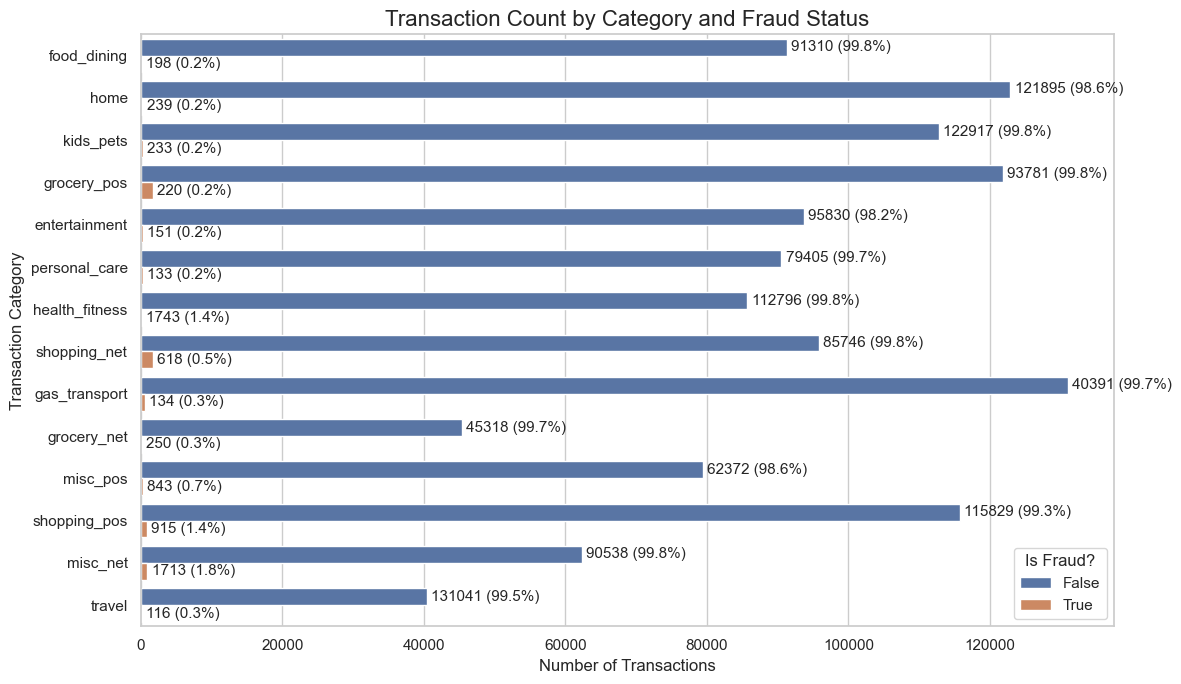

In [17]:
category_fraud_counts = df_enriched.groupBy("category", "is_fraud").count().toPandas()
category_fraud_counts['category_total'] = category_fraud_counts.groupby('category')['count'].transform('sum')
category_fraud_counts['percentage'] = (category_fraud_counts['count'] / category_fraud_counts['category_total']) * 100

labels_false = category_fraud_counts[category_fraud_counts['is_fraud'] == False].apply(
    lambda row: f"{row['count']} ({row['percentage']:.1f}%)", axis=1
)

labels_true = category_fraud_counts[category_fraud_counts['is_fraud'] == True].apply(
    lambda row: f"{row['count']} ({row['percentage']:.1f}%)", axis=1
)

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=category_fraud_counts,
    x="count",
    y="category",
    hue="is_fraud",
    orient='h'
)
plt.title("Transaction Count by Category and Fraud Status", fontsize=16)
plt.xlabel("Number of Transactions", fontsize=12)
plt.ylabel("Transaction Category", fontsize=12)
plt.legend(title="Is Fraud?")

ax.bar_label(ax.containers[0], labels=labels_false, fontsize=11, padding=3)
ax.bar_label(ax.containers[1], labels=labels_true, fontsize=11, padding=3)

plt.tight_layout()
plt.show()

This initial chart immediately reveals that while fraud is a rare event overall, the categories of misc_net (1.8%) and shopping_pos (1.4%) have the highest proportional fraud rates. This finding tells us what kinds of transactions are riskiest. This prompts an investigation into the financial nature of these attacks to determine the typical monetary value of a fraudulent transaction.

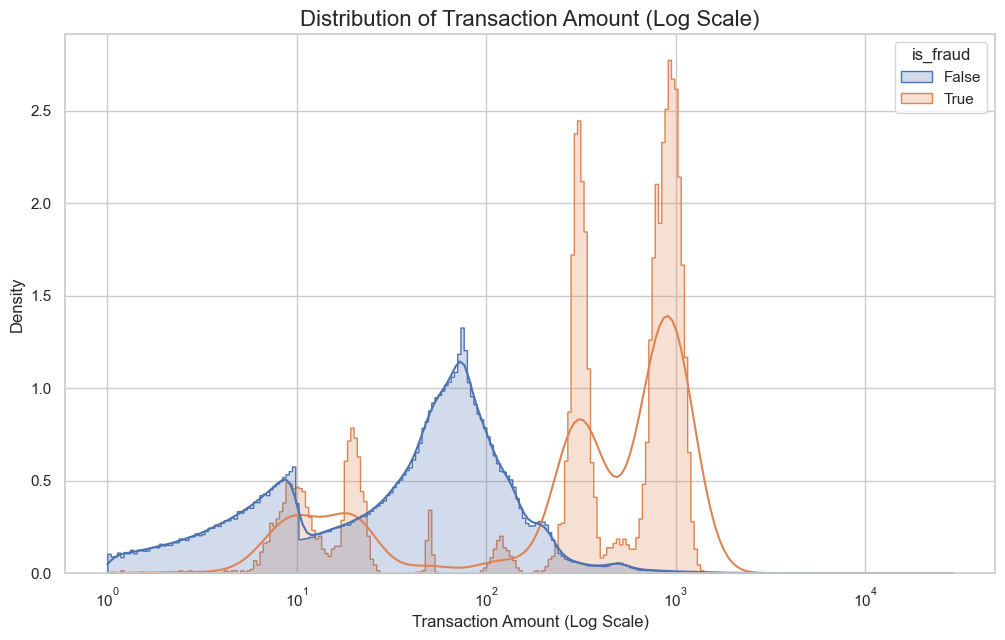

In [18]:
amt_data_pd = df_enriched.select("amt", "is_fraud").toPandas()

plt.figure(figsize=(12, 7))
sns.histplot(
    data=amt_data_pd,
    x="amt",
    hue="is_fraud",
    kde=True,  
    log_scale=True, 
    element="step",
    stat="density",
    common_norm=False
)
plt.title("Distribution of Transaction Amount (Log Scale)", fontsize=16)
plt.xlabel("Transaction Amount (Log Scale)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.show()

The distribution of transaction amounts makes the fraudsters' strategy clear. Legitimate spending is concentrated in the everyday $10-$100 range, whereas fraudulent spending is heavily skewed towards much higher values, with a massive peak around the $1,000 mark. This indicates a clear pattern of targeting high-value items. 
<br><br>
Knowing that fraudsters are making high-value purchases, the analysis can now turn to when these attacks are occurring.

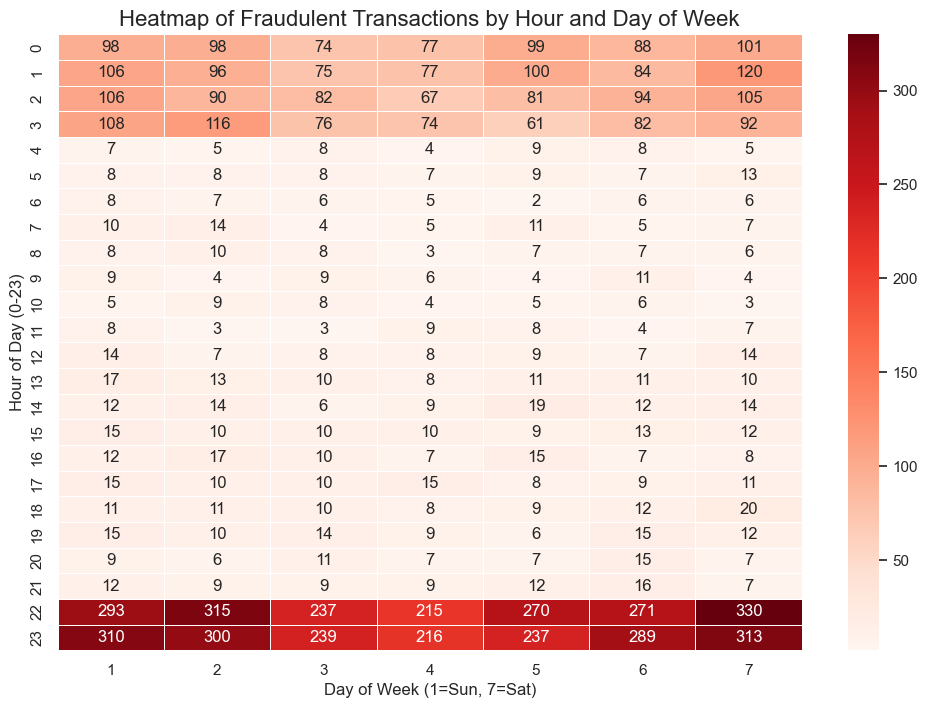

In [19]:
fraud_by_time = (
    df_enriched
    .filter(col("is_fraud") == True)
    .groupBy("hour_of_day", "day_of_week") 
    .count()
    .toPandas()
)

heatmap_data = fraud_by_time.pivot_table(
    index="hour_of_day",
    columns="day_of_week",
    values="count"
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt="g", linewidths=.5)
plt.title("Heatmap of Fraudulent Transactions by Hour and Day of Week", fontsize=16)
plt.xlabel("Day of Week (1=Sun, 7=Sat)", fontsize=12)
plt.ylabel("Hour of Day (0-23)", fontsize=12)
plt.show()

The heatmap provides a stunningly clear answer. The fraudulent activity is overwhelmingly concentrated in the late-night and very early morning hours, peaking sharply at 10 PM and 11 PM. This indicates that fraudsters are operating when they believe victims are asleep and monitoring is at its lowest.
<br><br>
The story so far is one of high-value, late-night fraud, which suggests online or remote activity. This naturally leads to a geographical analysis of the transactions.

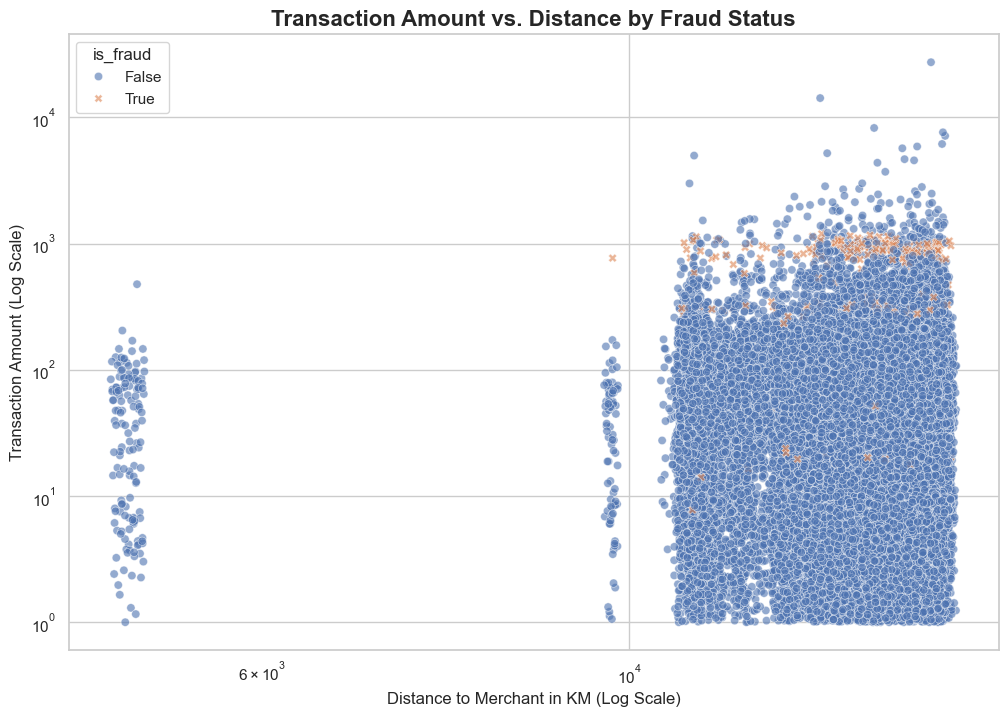

In [20]:
scatter_data_pd = (
    df_enriched
    .select("amt", "distance_to_merchant_km", "is_fraud")
    .sample(withReplacement=False, fraction=0.05, seed=42)
    .toPandas()
)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=scatter_data_pd,
    x="distance_to_merchant_km",
    y="amt",
    hue="is_fraud",
    alpha=0.6,
    style="is_fraud"
)
plt.xscale('log')
plt.yscale('log')
plt.title("Transaction Amount vs. Distance by Fraud Status", fontsize=16, fontweight='bold')
plt.xlabel("Distance to Merchant in KM (Log Scale)", fontsize=12)
plt.ylabel("Transaction Amount (Log Scale)", fontsize=12)
plt.show()

This plot ties the previous findings together, revealing a powerful interaction effect where fraudulent transactions are almost exclusively clustered in a very specific "fraud zone": high transaction amounts combined with long distances. A legitimate transaction might be high-value or long-distance, but it's rarely both; a fraudulent one almost always is.
<br><br>
To ensure this pattern is a reliable indicator, it must be verified across different transaction categories, as a long-distance transaction for online shopping is normal, but one for buying gas is not.

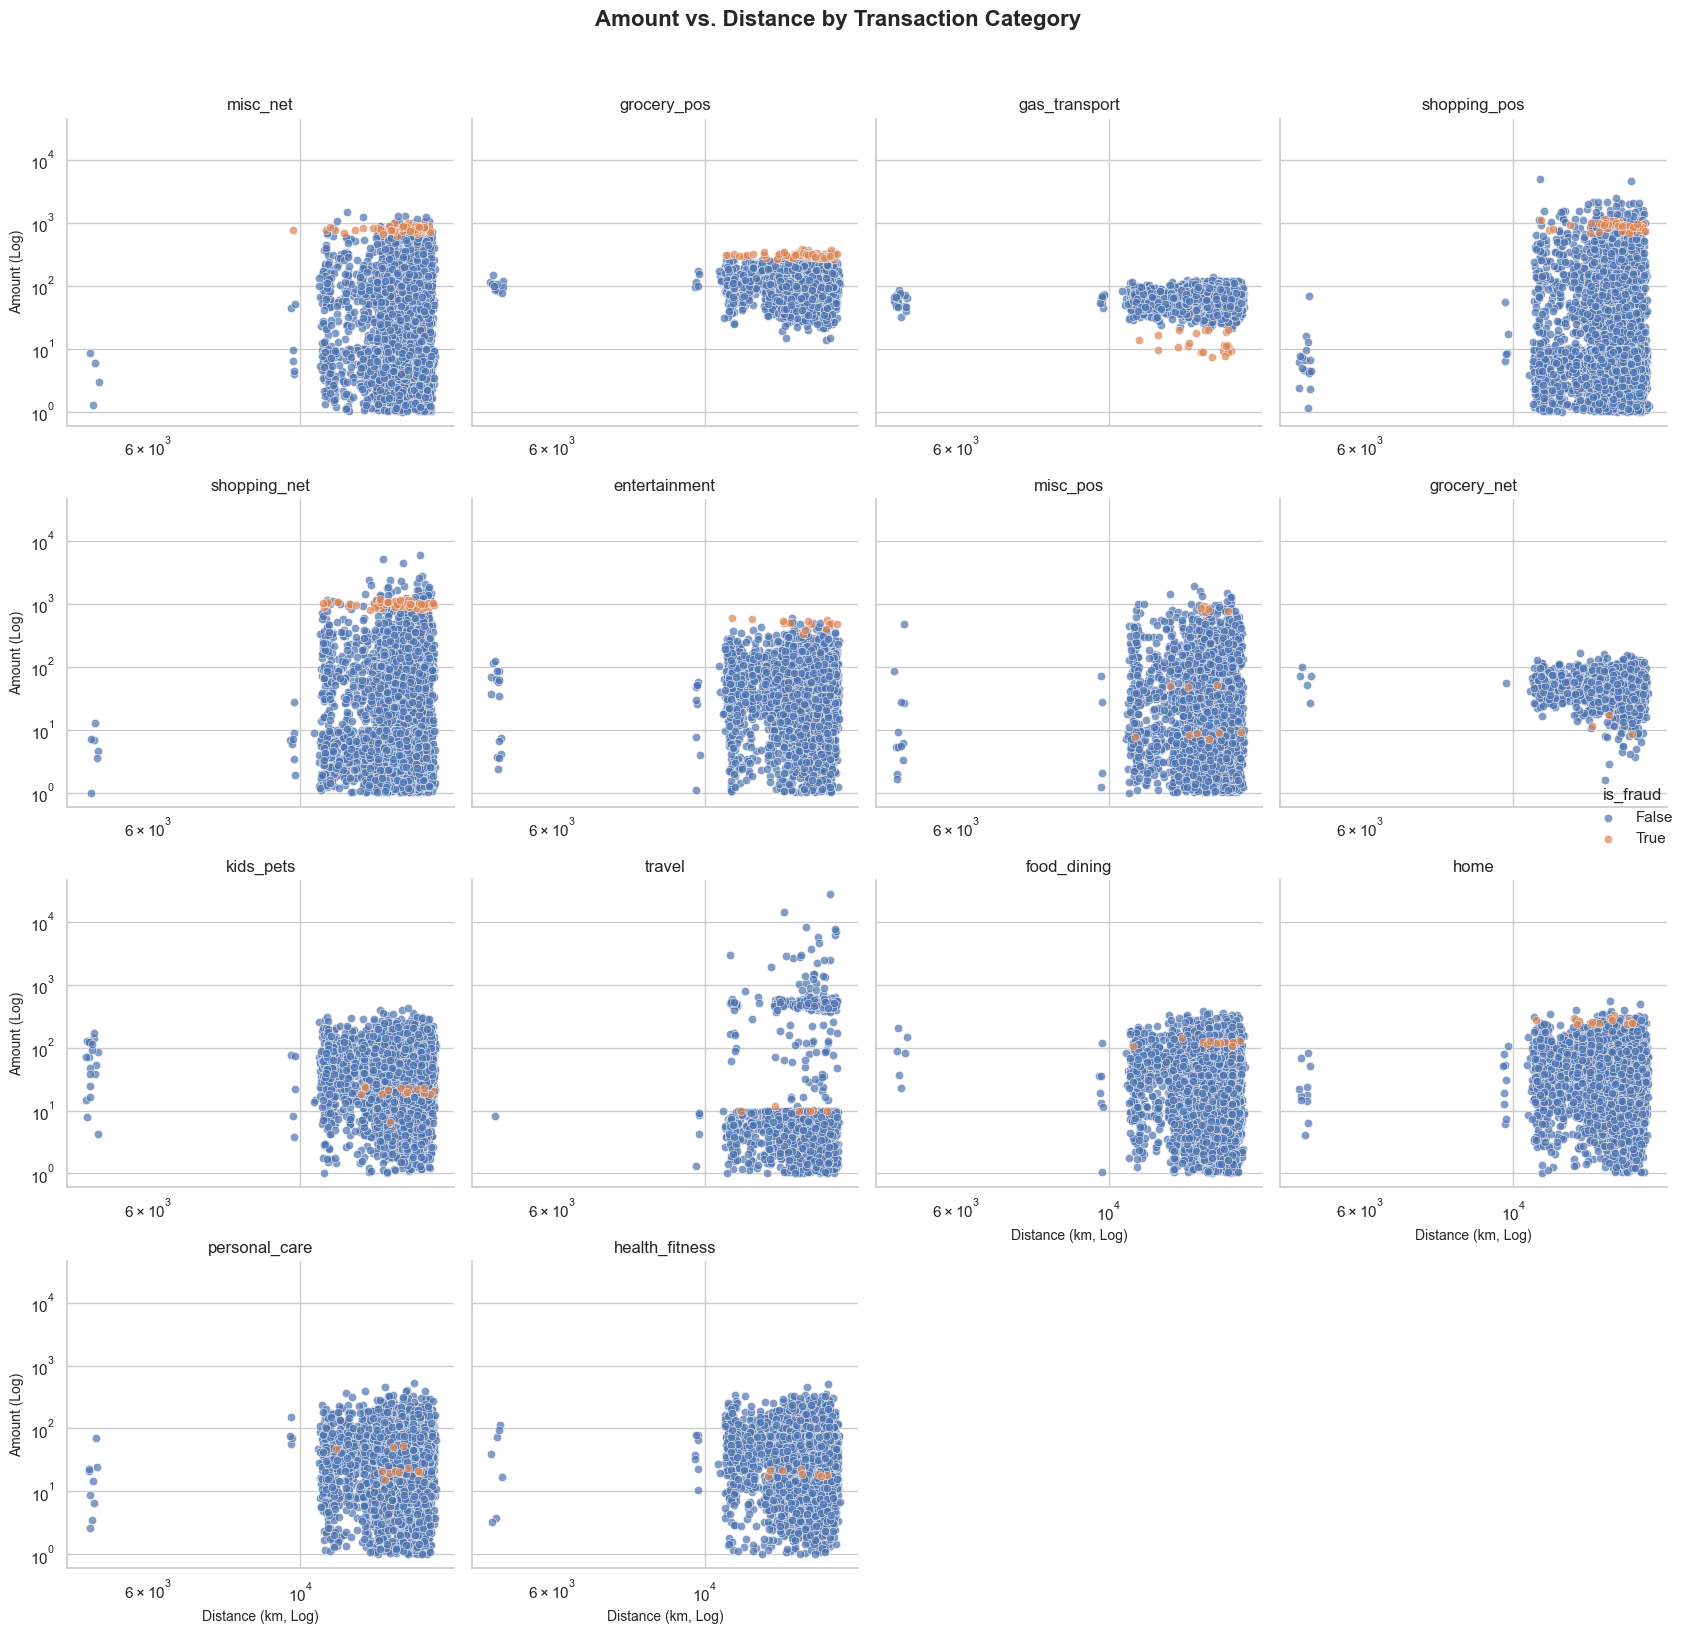

In [21]:
facet_data_pd = (
    df_enriched
    .select("amt", "distance_to_merchant_km", "category", "is_fraud")
    .sample(withReplacement=False, fraction=0.05, seed=42)
    .toPandas()
)

g = sns.FacetGrid(facet_data_pd, col="category", hue="is_fraud", col_wrap=4, height=4)

g.map(sns.scatterplot, "distance_to_merchant_km", "amt", alpha=0.7)

g.set_titles("{col_name}")
g.set_xlabels("Distance (km, Log)", fontsize=10)
g.set_ylabels("Amount (Log)", fontsize=10)
g.set(xscale="log", yscale="log")
g.add_legend()
g.fig.suptitle('Amount vs. Distance by Transaction Category', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

This detailed view confirms the story and adds a critical new chapter. The "high amount, high distance" fraud signature is strongest in online categories like `misc_net`. Even more revealing is the pattern in categories that should be in-person, like `gas_transport` and `grocery_pos`. Here, the fraudulent transactions occur exclusively at long distances, which is a massive red flag and a near-certain indicator of fraud.
<br><br>
With a clear picture of how fraud is committed, the analysis can now shift to understanding who is most frequently targeted. A good starting point is to see if the fraudsters' strategy changes based on the victim's age.

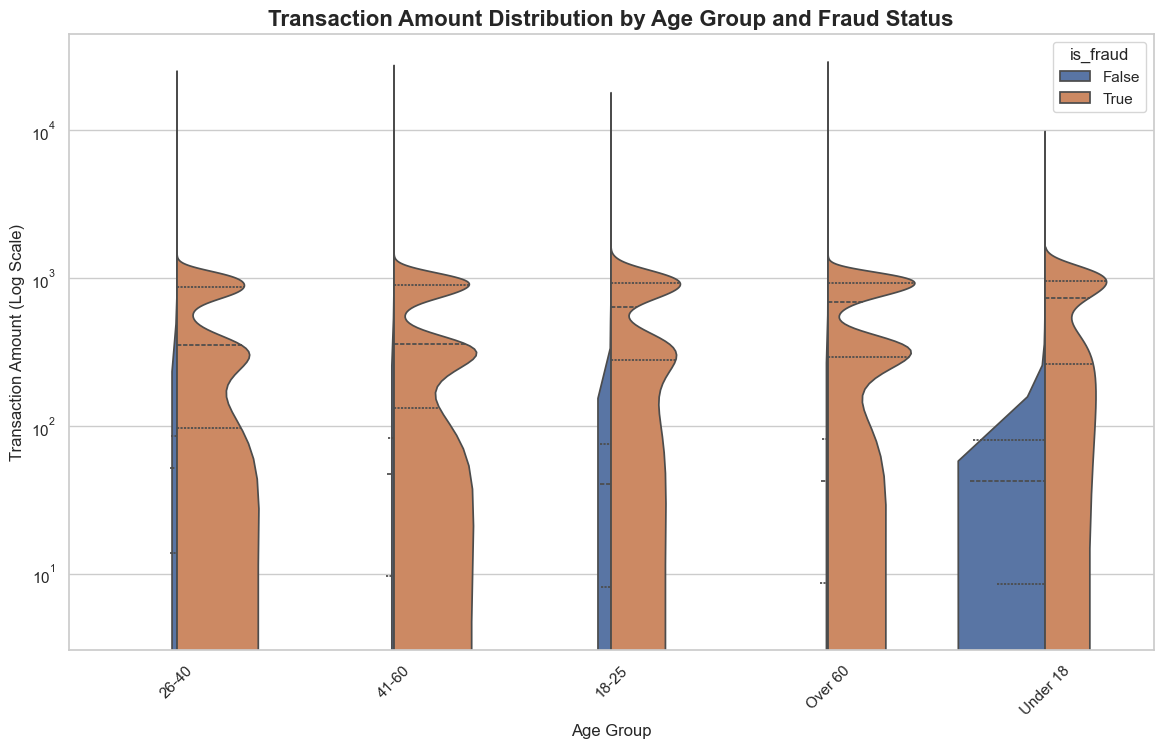

In [22]:
age_amt_data_pd = (
    df_enriched
    .select("amt", "age_group", "is_fraud")
    .toPandas()
)

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=age_amt_data_pd,
    x="age_group",
    y="amt",
    hue="is_fraud",
    split=True,
    inner="quart"
)
plt.yscale('log')
plt.title("Transaction Amount Distribution by Age Group and Fraud Status", fontsize=16, fontweight='bold')
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Transaction Amount (Log Scale)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

This plot reveals that the fraudsters' strategy is remarkably consistent. The bimodal fraud pattern, with a primary peak around $1,000, is present across all age groups. However, the legitimate spending patterns of the adult groups are very similar, while the "Under 18" group is a distinct outlier, with much lower typical spending. This makes the high-value fraud on their accounts even more anomalous and a stronger indicator of risk compared to other demographics.
<br><br>
This confirms the fraud method is consistent across demographics. The analysis can now shift to determine if certain professions are more at risk of being targeted in the first place.

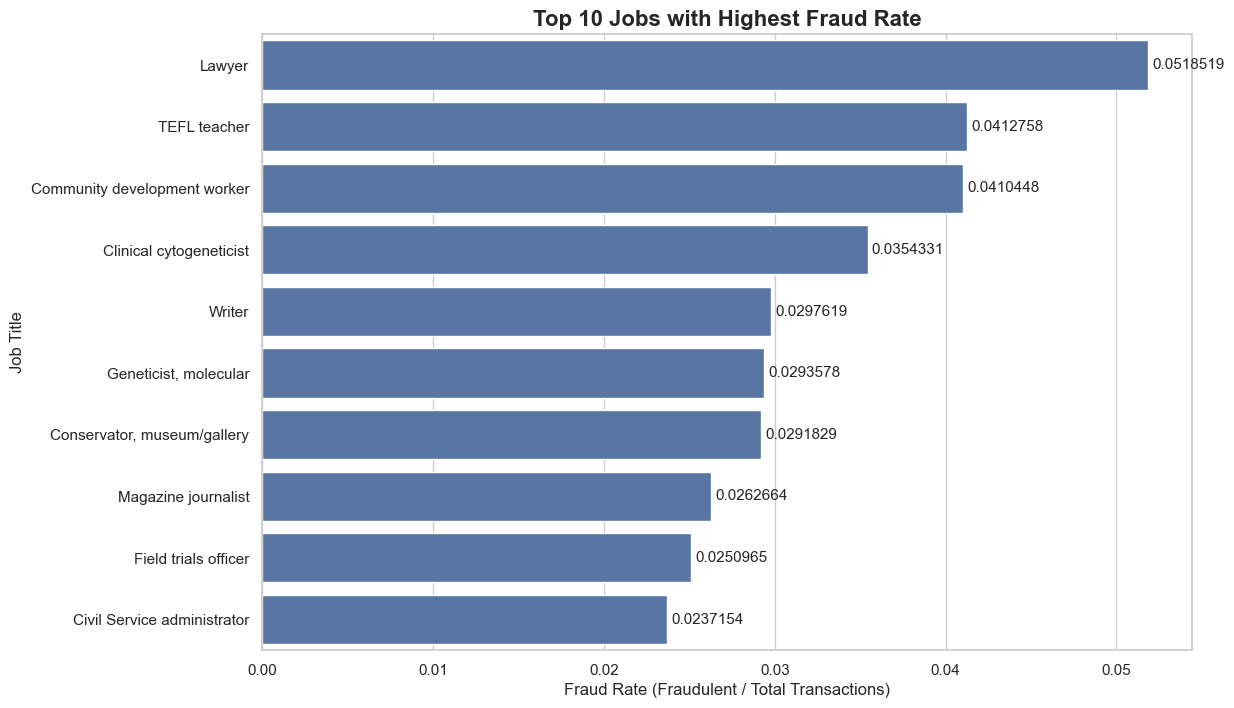

In [23]:
job_fraud_rate = (
    df_enriched.groupBy("job")
    .agg(
        sum(col("is_fraud").cast(IntegerType())).alias("fraud_count"),
        count("*").alias("total_count")
    )
    .withColumn("fraud_rate", col("fraud_count") / col("total_count"))
    .filter(col("total_count") > 50)
    .orderBy(col("fraud_rate").desc())
    .limit(10)
    .toPandas()
)

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=job_fraud_rate,
    x="fraud_rate",
    y="job"
)
plt.title("Top 10 Jobs with Highest Fraud Rate", fontsize=16, fontweight='bold')
plt.xlabel("Fraud Rate (Fraudulent / Total Transactions)", fontsize=12)
plt.ylabel("Job Title", fontsize=12)

ax.bar_label(ax.containers[0], fontsize=11, padding=3)

plt.show()

This chart shows that the risk is not evenly distributed among the population. Professionals like Lawyers have a fraud rate approaching 5.5%, significantly higher than the dataset's overall average, which suggests that certain professions are disproportionately targeted.
<br><br>
Finally, to summarize the geographical aspect of our story, all fraudulent merchant locations can be plotted on a map.

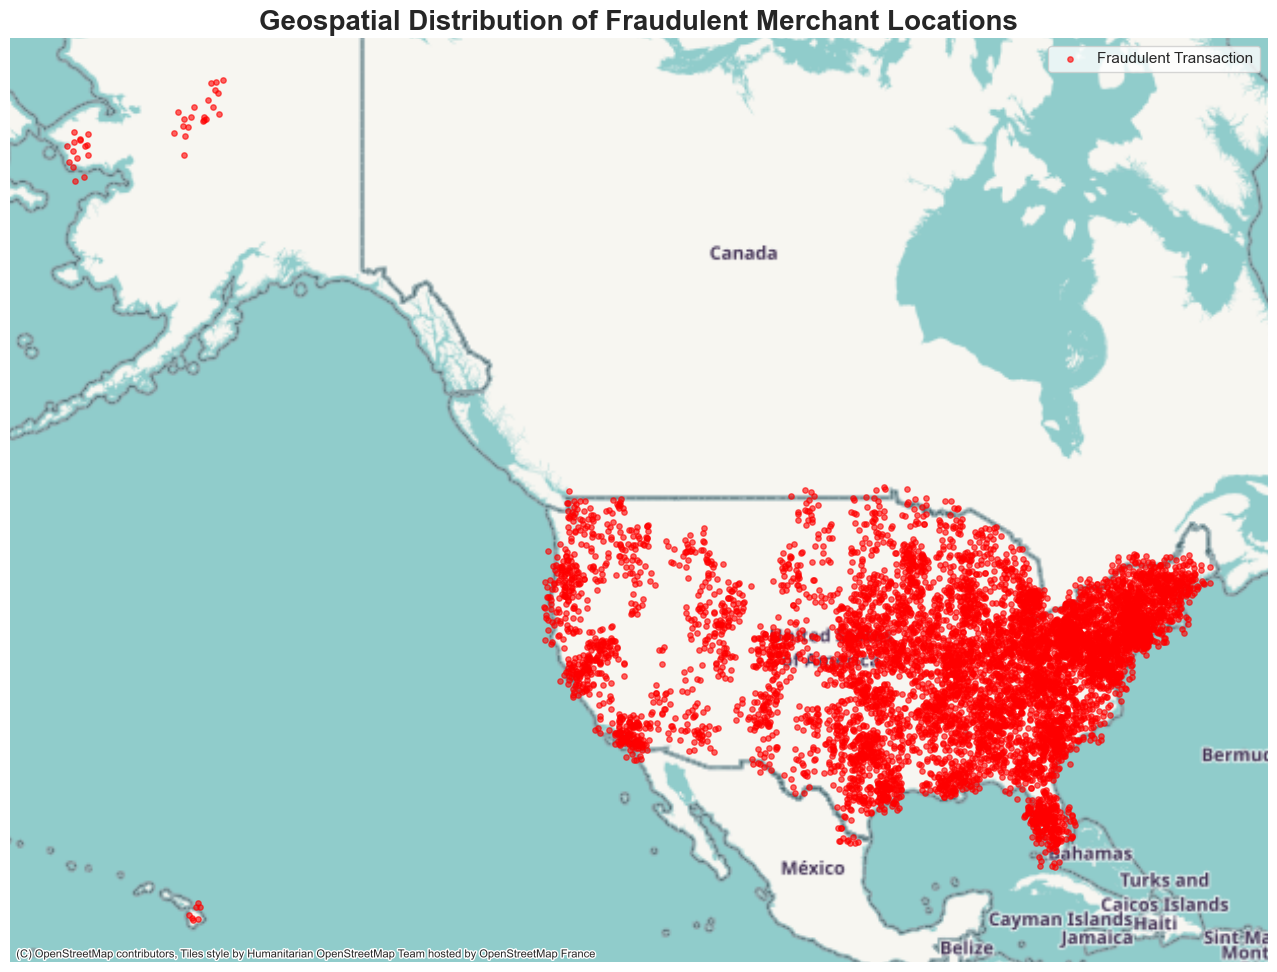

In [24]:
fraud_locations_pd = (
    df_enriched
    .filter(col("is_fraud") == True)
    .select("merch_lat", "merch_long")
    .toPandas()
)
fraud_locations_pd.dropna(subset=['merch_lat', 'merch_long'], inplace=True)

geometry = [Point(xy) for xy in zip(fraud_locations_pd['merch_long'], fraud_locations_pd['merch_lat'])]
gdf_fraud = geopandas.GeoDataFrame(fraud_locations_pd, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(18, 12))

gdf_fraud_web_mercator = gdf_fraud.to_crs(epsg=3857)

gdf_fraud_web_mercator.plot(ax=ax, marker='o', color='red', markersize=15, alpha=0.6, label='Fraudulent Transaction')

ctx.add_basemap(ax)

ax.set_title('Geospatial Distribution of Fraudulent Merchant Locations', fontsize=20, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.legend()

ax.set_axis_off()

plt.show()

The map confirms the long-distance nature of the fraud we discovered. The activity is heavily concentrated within the United States, particularly in the eastern half, reinforcing that this is not random but a targeted campaign with a clear geographical footprint.

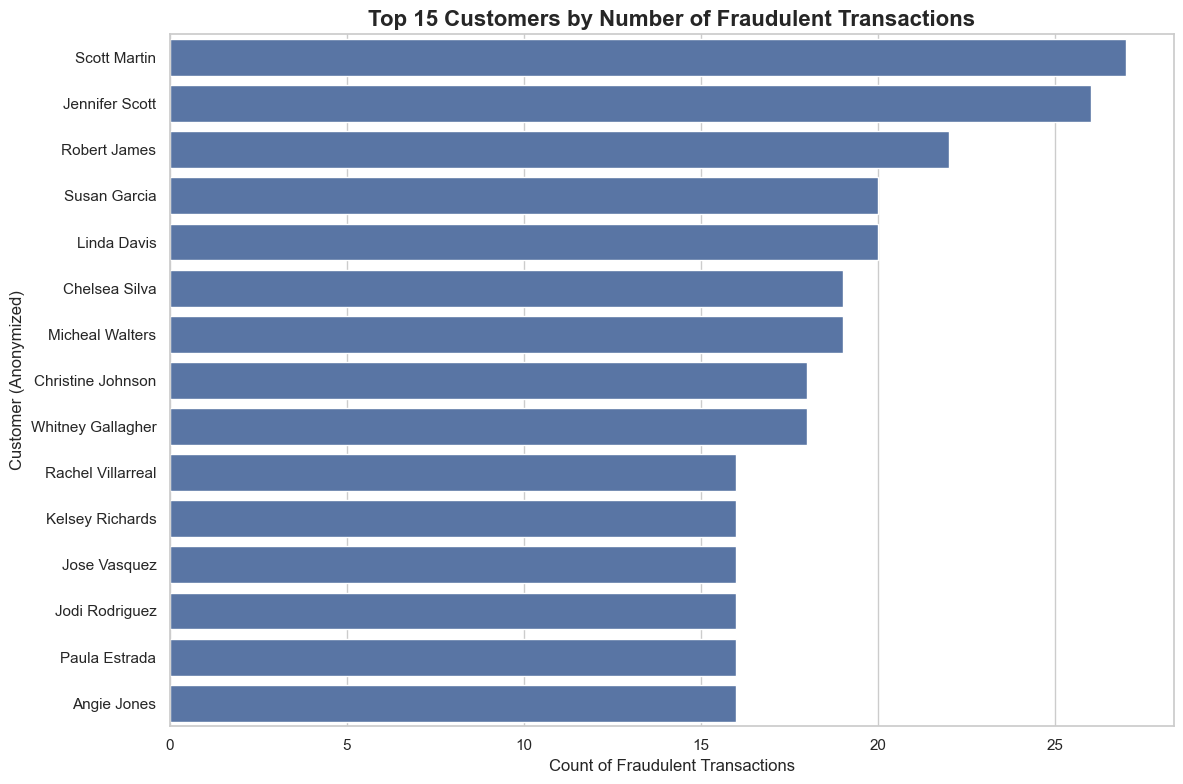

In [25]:
df_with_customer_id = df_enriched.withColumn("customer_id", concat_ws(" ", col("First"), col("Last")))

top_fraud_customers = (df_with_customer_id.filter(col("is_fraud") == True) 
    .groupBy("customer_id") 
    .count() 
    .orderBy(col("count").desc())
    .limit(15)
    .toPandas()
)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_fraud_customers, x="count", y="customer_id")
plt.title("Top 15 Customers by Number of Fraudulent Transactions", fontsize=16, fontweight='bold')
plt.xlabel("Count of Fraudulent Transactions", fontsize=12)
plt.ylabel("Customer (Anonymized)", fontsize=12)
plt.tight_layout()
plt.show()